# 추론 기반 기법과 신경망

### 3.1.3 신경망에서의 단어처리
![image.png](./img/3-1.png)
신경망을 이용해 '단어'를 처리한다. 단어를 '고정 길이의 벡터'로 변환하기 위해, **원핫 벡터**를 사용하여 변환한다.
![image.png](./img/3-2.png)
입력층의 뉴련 : 각 뉴런이 각 단어에 대응
![image.png](./img/3-3.png)
완전연결계층에 의한 변환: 입력층의 각 뉴련은 7개의 단어 각각에 대응한다.(은닉층 뉴런은 3개를 준비함)
c는 원핫 표현이므로 단어 ID에 대응하는 원소만 1이고 그 외에는 0인 벡터이다. 따라서 h는 가중치의 행벡터 하나를 '뽑아낸' 것과 같다.
![image.png](./img/3-4.png)

In [2]:
import  numpy as np

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력
W = np.random.randn(7, 3) # 가중치
h = np.matmul(c, W) # 중간 노드
print(h)

[[-1.8292028  -1.21867646  0.05741966]]


In [4]:
import sys
sys.path.append('..')
from common.layers import MatMul

c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력
W = np.random.randn(7, 3) # 가중치
layer = MatMul(W)
h = layer.forward(c)
print(h)

[[ 1.14153884  0.27295429 -0.08272128]]


## 3.2 단순한 word2vec

### 3.2.1 CBOW 모델의 추론 처리
**CBOW** 모델은 맥락으로부터 타깃을 추측하는 용도의 신경망
- 맥락을 원핫 표현으로 변환하여 CBOW 모델이 처리할 수 있도록 준비.
![image.png](./img/3-5.png)
 
> 이 그림에서 입력층이 2개인 이유는 맥락으로 고려할 단어를 2개로 정했기 때문이다.
즉, 맥락에 포함시킬 단어가 N개라면 입력층도 N개가 되어야한다.

![image.png](./img/3-6.png)

> 계층 관점에서 본 CBOW 모델의 신경망 구성 입력층이 2개이기 때문에 (h1+h2)/2로 평균값을 구한다

보았듯이 CBOW 모델은 활성화 함수를 사용하지 않는 간단한 구성의 신경망이다.

In [6]:
# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-1.59756613  1.91167236  1.19265239  0.47494206  1.32799998 -0.99693663
   2.16783   ]]


### 3.2.2 CBOW 모델의 학습
전에 각 단어의 점수를 출력하였는데, 이 점수에 소프트 맥스 함수를 적용하면 '확률'을 얻을 수 있다. 이 확률은 맥락(전후 단어)가 주어졌었을 때 그 중앙에 어떤 단어가 출현하는지를 나타낸다.
'you'와 'goodbye' 사이에는 'say'가 나와야한다.
![image.png](./img/3-7.png)
이 신경망을 학습하려면 소프트맥스와 교차 엔트로피 오차만 이용하면 된다. 소프트맥스 함수를 이용해 점수를 확률로 바꾸고, 그 확률과 점수 레이블로부터 교차 엔트로피 오차를 구한 후, 그 값을 손실로 사용해 학습을 진행한다.
![image.png](./img/3-8.png)

### word2vec의 가중치와 분산 표현
입력 측 가중치의 각 행이 각 단어의 분산 표현에 해당한다. 출력 측 가중치에도 단어의 의미가 인코딩된 벡터가 저장되고 있다고 생각할 수 있다. 다만, 출력 측 가중치는 단어의 분산 표현이 열방향으로 저장된다.
![image.png](./img/3-9.png)

## 3.3 학습 데이터 준비

### 3.3.1 맥락과 타깃
![image.png](./img/3-10.png)

In [7]:
from common.util import preprocess

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

[0 1 2 3 4 1 5 6]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}


![image.png](./img/3-11.png)
맥락과 타깃을 작성하는 함수

In [11]:
def create_contexts_target(corpus, window_size=1):
    target = corpus[window_size:-window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0:
                continue
            cs.append(corpus[idx + t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [12]:
contexts, target = create_contexts_target(corpus, window_size =1)
print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]
 [1 6]]
[1 2 3 4 1 5]


### 3.3.2 원핫 표현으로 변환
말뭉치로부터 맥락과 타깃을 만들어냈는데, 이 맥락과 타깃의 각 원소를 원 핫 표현으로 변환해야 한다.
![image.png](./img/3-12.png)

In [14]:
def convert_one_hot(corpus, vocab_size):
    '''원핫 표현으로 변환

    :param corpus: 단어 ID 목록(1차원 또는 2차원 넘파이 배열)
    :param vocab_size: 어휘 수
    :return: 원핫 표현(2차원 또는 3차원 넘파이 배열)
    '''
    N = corpus.shape[0]

    if corpus.ndim == 1:
        one_hot = np.zeros((N, vocab_size), dtype=np.int32)
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1

    elif corpus.ndim == 2:
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype=np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids):
                one_hot[idx_0, idx_1, word_id] = 1

    return one_hot

In [15]:
vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

## 3.4 CBOW 모델 구현

In [28]:
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer_0 = MatMul(W_in)
        self.in_layer_1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer_0, self.in_layer_1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
    
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
    def forward(self, contexts, target):
        h0 = self.in_layer_0.forward(contexts[:, 0])
        h1 = self.in_layer_1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer_1.backward(da)
        self.in_layer_0.backward(da)
        return None

### 3.4.1 학습 코드 구현

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 205 |  반복 1 / 2 | 시간 0[s] | 손실 1.22
| 에폭 206 |  반복 1 / 2 | 시간 0[s] | 손실 1.24
| 에폭 207 |  반복 1 / 2 | 시간 0[s] | 손실 1.21
| 에폭 208 |  반복 1 / 2 | 시간 0[s] | 손실 1.23
| 에폭 209 |  반복 1 / 2 | 시간 0[s] | 손실 1.20
| 에폭 210 |  반복 1 / 2 | 시간 0[s] | 손실 1.22
| 에폭 211 |  반복 1 / 2 | 시간 0[s] | 손실 1.20
| 에폭 212 |  반복 1 / 2 | 시간 0[s] | 손실 1.14
| 에폭 213 |  반복 1 / 2 | 시간 0[s] | 손실 1.26
| 에폭 214 |  반복 1 / 2 | 시간 0[s] | 손실 1.26
| 에폭 215 |  반복 1 / 2 | 시간 0[s] | 손실 1.12
| 에폭 216 |  반복 1 / 2 | 시간 0[s] | 손실 1.25
| 에폭 217 |  반복 1 / 2 | 시간 0[s] | 손실 1.05
| 에폭 218 |  반복 1 / 2 | 시간 0[s] | 손실 1.25
| 에폭 219 |  반복 1 / 2 | 시간 0[s] | 손실 1.25
| 에폭 220 |  반복 1 / 2 | 시간 0[s] | 손실 1.10
| 에폭 221 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 222 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 223 |  반복 1 / 2 | 시간 0[s] | 손실 1.17
| 에폭 224 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 225 |  반복 1 / 2 | 시간 0[s] | 손실 1.23
| 에폭 226 |  반복 1 / 2 | 시간 0[s] | 손실 1.08
| 에폭 227 |  반복 1 / 2 | 시간 0[s] | 손실 1.22
| 에폭 228 |  반복 1 / 2 | 시간 0[s] | 손실 1.15
| 에폭 229 |  반복 1

| 에폭 407 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 408 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 409 |  반복 1 / 2 | 시간 0[s] | 손실 0.85
| 에폭 410 |  반복 1 / 2 | 시간 0[s] | 손실 0.57
| 에폭 411 |  반복 1 / 2 | 시간 0[s] | 손실 0.70
| 에폭 412 |  반복 1 / 2 | 시간 0[s] | 손실 0.98
| 에폭 413 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 414 |  반복 1 / 2 | 시간 0[s] | 손실 0.90
| 에폭 415 |  반복 1 / 2 | 시간 0[s] | 손실 0.77
| 에폭 416 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 417 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 418 |  반복 1 / 2 | 시간 0[s] | 손실 0.84
| 에폭 419 |  반복 1 / 2 | 시간 0[s] | 손실 0.76
| 에폭 420 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 421 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 422 |  반복 1 / 2 | 시간 0[s] | 손실 0.82
| 에폭 423 |  반복 1 / 2 | 시간 0[s] | 손실 0.71
| 에폭 424 |  반복 1 / 2 | 시간 0[s] | 손실 0.89
| 에폭 425 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 426 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 427 |  반복 1 / 2 | 시간 0[s] | 손실 0.81
| 에폭 428 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 429 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 430 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 431 |  반복 1

| 에폭 809 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 810 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 811 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 812 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 813 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 814 |  반복 1 / 2 | 시간 0[s] | 손실 0.68
| 에폭 815 |  반복 1 / 2 | 시간 0[s] | 손실 0.40
| 에폭 816 |  반복 1 / 2 | 시간 0[s] | 손실 0.72
| 에폭 817 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 818 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 819 |  반복 1 / 2 | 시간 0[s] | 손실 0.67
| 에폭 820 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 821 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 822 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 823 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 824 |  반복 1 / 2 | 시간 0[s] | 손실 0.49
| 에폭 825 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 826 |  반복 1 / 2 | 시간 0[s] | 손실 0.44
| 에폭 827 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 828 |  반복 1 / 2 | 시간 0[s] | 손실 0.62
| 에폭 829 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 830 |  반복 1 / 2 | 시간 0[s] | 손실 0.60
| 에폭 831 |  반복 1 / 2 | 시간 0[s] | 손실 0.51
| 에폭 832 |  반복 1 / 2 | 시간 0[s] | 손실 0.37
| 에폭 833 |  반복 1

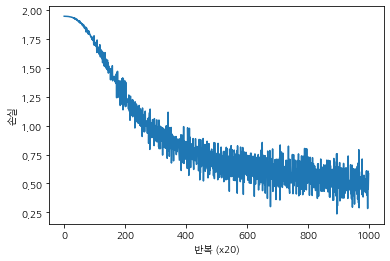

In [29]:
from common.trainer import Trainer
from common.optimizer import Adam

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [31]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [ 0.93948716  1.1471828   0.9876904  -1.5107943  -0.9072483 ]
say [-1.2550594  -0.33916035 -1.2577727  -0.15432052  1.2682257 ]
goodbye [ 1.0768011   0.69896984  1.0905025  -0.17019284 -1.0796039 ]
and [-1.0884993 -1.5440016 -1.1070035  1.603704   1.11817  ]
i [ 1.0628144  0.6580432  1.08559   -0.1830638 -1.0735143]
hello [ 0.9399647  1.1701053  0.9819399 -1.5028169 -0.9213758]
. [-1.0079472  1.4644911 -0.9318077 -1.3403562  1.0558087]
